In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model

%matplotlib inline

[Here is a link](https://cran.r-project.org/web/packages/recommenderlab/vignettes/recommenderlab.pdf) to a paper describing a framework for evaluating recommender systems.

[Here is a blog post](https://rpubs.com/jt_rpubs/285729) that details an attempt at benchmarking this dataset.

[Here is the stable link](http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip) for getting the joke texts.

In [3]:
path = 'data/jester/'
train = pd.concat((pd.read_csv(path+file) for file in ['train1.csv', 'train2.csv']), ignore_index=True)
test = pd.read_csv(path+'test.csv')

In [4]:
train.head()

,userId,jokeId,rating
0,13665,75,3.64
1,69454,54,4.85
2,58909,46,-4.37
3,42373,11,1.26
4,25959,37,-8.88


In [5]:
train.shape

(3308968, 3)

In [6]:
n_users = train.userId.nunique()
n_items = train.jokeId.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 73418
Number of items: 100


In [7]:
max_users = train.userId.max()
max_items = train.jokeId.max()
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 73417
Max movie ID: 99


## Dot product model

In [10]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(n_items, 5, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         500         Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         367090      User-Input[0][0]                 
____________________________________________________________________________________________

Train on 3308968 samples
Epoch 1/5
3308968/3308968 [==============================] - 96s 29us/sample - loss: 15.8258
Epoch 2/5
3308968/3308968 [==============================] - 98s 30us/sample - loss: 15.5974
Epoch 3/5
3308968/3308968 [==============================] - 99s 30us/sample - loss: 15.4318
Epoch 4/5
3308968/3308968 [==============================] - 109s 33us/sample - loss: 15.3151
Epoch 5/5
3308968/3308968 [==============================] - 109s 33us/sample - loss: 15.2299


Text(0, 0.5, 'Training Error')

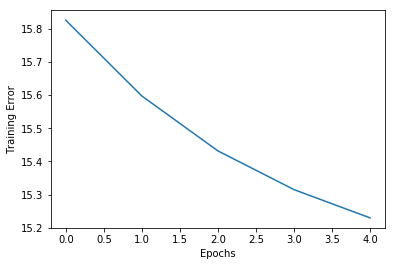

In [12]:
history = model.fit([train.userId, train.jokeId], train.rating, batch_size=256, epochs=5, verbose=1)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [14]:
model.evaluate([test.userId, test.jokeId], test.rating, batch_size=1028)

827242/827242 [==============================] - 1s 1us/sample - loss: 17.8927


17.892710752463042

In [15]:
np.sqrt(17.8927)

4.229976359271999

In [17]:
predictions = model.predict([test.userId.head(10), test.jokeId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.4885178] 6.07
[-3.672791] -6.65
[3.090424] 3.69
[1.9755636] 3.06
[-2.3807676] -5.92
[2.7527246] -0.29
[3.297278] 3.88
[1.5360204] -1.7
[-3.035904] -7.62
[0.58468765] 0.49


[None, None, None, None, None, None, None, None, None, None]

## Neural network model

In [69]:
from tensorflow.keras import backend as K

def stretch(x):
    return K.tanh(x) * 10

In [70]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(n_items, 5, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=squeeze)(d2)

# Create model and compile it
model2 = Model([user_input, item_input], out)
model2.compile('adam', 'mean_squared_error')
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 10)        1000        Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        734180      User-Input[0][0]                 
____________________________________________________________________________________________

Train on 3308968 samples
Epoch 1/10
3308968/3308968 [==============================] - 144s 44us/sample - loss: 21.2618
Epoch 2/10
3308968/3308968 [==============================] - 159s 48us/sample - loss: 19.4600
Epoch 3/10
3308968/3308968 [==============================] - 167s 50us/sample - loss: 18.9616
Epoch 4/10
3308968/3308968 [==============================] - 165s 50us/sample - loss: 18.6187
Epoch 5/10
3308968/3308968 [==============================] - 170s 52us/sample - loss: 18.3675
Epoch 6/10
3308968/3308968 [==============================] - 177s 54us/sample - loss: 18.1597
Epoch 7/10
3308968/3308968 [==============================] - 178s 54us/sample - loss: 17.9778
Epoch 8/10
3308968/3308968 [==============================] - 181s 55us/sample - loss: 17.8193
Epoch 9/10
3308968/3308968 [==============================] - 167s 50us/sample - loss: 17.6748
Epoch 10/10
3308968/3308968 [==============================] - 167s 50us/sample - loss: 17.5192


Text(0, 0.5, 'Training Error')

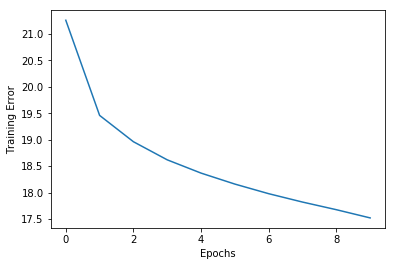

In [71]:
history = model2.fit([train.userId, train.jokeId], train.rating, batch_size=256, epochs=10)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [72]:
model2.evaluate([test.userId, test.jokeId], test.rating, batch_size=1028)

827242/827242 [==============================] - 2s 3us/sample - loss: 18.1876


18.187626275069505

In [73]:
np.sqrt(17.925)

4.23379262600331

In [75]:
predictions = model2.predict([test.userId.head(10), test.jokeId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.871613] 6.07
[-3.4962404] -6.65
[3.144096] 3.69
[2.489019] 3.06
[-1.0003625] -5.92
[0.31549513] -0.29
[2.0854447] 3.88
[1.3752179] -1.7
[-3.4700549] -7.62
[-0.54237914] 0.49


[None, None, None, None, None, None, None, None, None, None]

## Visualise embeddings

In [27]:
# Extract embeddings
item_em = model2.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [28]:
item_em_weights[:5]

array([[-0.37969637, -0.05100399, -0.3908827 , -0.4976982 ,  0.18290104],
       [ 0.14102285, -0.36055663, -0.03878346, -0.50621617, -0.04054279],
       [-0.04794914,  0.02027828, -0.38932633, -0.5307747 , -0.15809813],
       [ 0.3331978 ,  0.02202632, -0.13751261, -0.38647372, -0.60944796],
       [-0.09943481, -0.59542817, -0.06787848, -0.37130022, -0.03313598]],
      dtype=float32)

In [30]:
item_em_weights.shape

(100, 5)

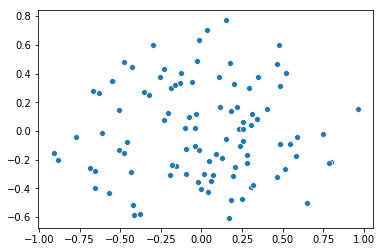

In [29]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [31]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

1.0

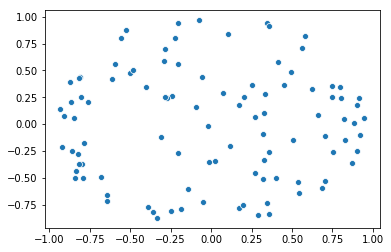

In [32]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.403276
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.907486
[t-SNE] KL divergence after 1000 iterations: 0.484392


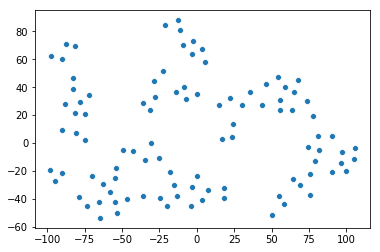

In [53]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

### User embeddings

In [59]:
# Extract embeddings
user_em = model2.get_layer('User-Embedding')
user_em_weights = user_em.get_weights()[0]

In [60]:
user_em_weights[:5]

array([[-0.92405844,  0.24366091,  0.5195896 ,  0.14215724,  0.27067202],
       [-0.43446285, -1.0510621 ,  0.9617875 , -0.8253407 , -0.9525767 ],
       [-0.48462918, -0.58874357,  0.5969208 , -0.16054139,  0.12488972],
       [-0.39076918, -0.5574343 ,  0.45930013, -0.11372289, -0.37930086],
       [ 0.8421923 ,  0.3207079 , -0.46160692,  0.4812237 ,  0.47544077]],
      dtype=float32)

In [61]:
user_em_weights.shape

(73418, 5)

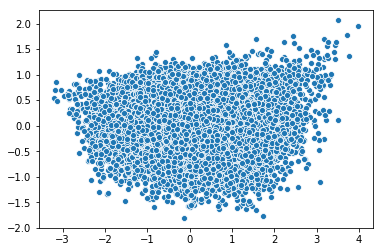

In [63]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [64]:
user_em_weights = user_em_weights / np.linalg.norm(user_em_weights, axis = 1).reshape((-1, 1))
user_em_weights[0][:10]
np.sum(np.square(user_em_weights[0]))

0.9999999

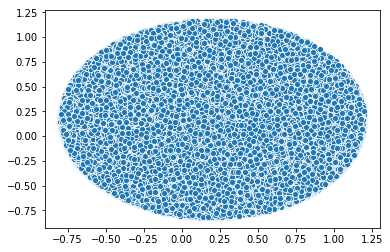

In [65]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', verbose=1)
tnse_results = tsne.fit_transform(user_em_weights)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 73418 samples in 0.052s...
[t-SNE] Computed neighbors for 73418 samples in 2.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 73418
[t-SNE] Computed conditional probabilities for sample 2000 / 73418
[t-SNE] Computed conditional probabilities for sample 3000 / 73418
[t-SNE] Computed conditional probabilities for sample 4000 / 73418
[t-SNE] Computed conditional probabilities for sample 5000 / 73418
[t-SNE] Computed conditional probabilities for sample 6000 / 73418
[t-SNE] Computed conditional probabilities for sample 7000 / 73418
[t-SNE] Computed conditional probabilities for sample 8000 / 73418
[t-SNE] Computed conditional probabilities for sample 9000 / 73418
[t-SNE] Computed conditional probabilities for sample 10000 / 73418
[t-SNE] Computed conditional probabilities for sample 11000 / 73418
[t-SNE] Computed conditional probabilities for sample 12000 / 73418
[t-SNE] Computed conditional probabilities for sam

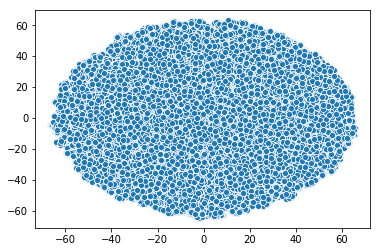

In [67]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [54]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.jokeId)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [55]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [56]:
predictions = model2.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([88, 71, 20, 49, 26], dtype=int64)

In [57]:
# print predicted scores
predictions[recommended_movie_ids]

array([8.8474  , 8.77411 , 8.733646, 8.707412, 8.648523], dtype=float32)